## Import Libraries

In [1]:
# Import libraries for data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
import os
import sys

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/My Drive/AirBNBCleaned.csv')

In [3]:
df.head(1)

,name,city,neighbourhood,zipcode,description,linear_price,property_type,room_type,accommodates,instant_bookable,...,air_conditioning,carbon_monoxide_detector,laptop_friendly_workspace,hair_dryer,kitchen,washer,dryer,kid_friendly,pool,iron
0,Beautiful brownstone 1-bedroom,NYC,Brooklyn Heights,11201,"Beautiful, sunlit brownstone 1-bedroom in the ...",0.074575,Apartment,Entire home/apt,3,0,...,1,0,0,1,1,0,1,1,0,1


In [4]:
# Remove all listings with an average review score below 90.0
df = df[df['review_scores_rating'] >= 90.0]


In [5]:
df.dropna(inplace=True)

In [6]:
df.shape

(36145, 35)

## Build a Neural Network to Predict the Linear Price

Here we're going to use the same model from our previous analysis to predict the linear price, then reiterate through every row while removing each variable. This way we'll find out just how much of an effect each variable has on the overall price of an AirBNB in each city.

In [7]:
# Select relevant features and a target variable
X = df[['bedrooms', 'beds', 'wireless_internet', 'smoke_detector', 'air_conditioning', 'carbon_monoxide_detector', 'laptop_friendly_workspace', 'hair_dryer', 'kitchen', 'washer', 'dryer', 'kid_friendly', 'pool', 'iron', 'instant_bookable', 'host_identity_verified', 'host_has_profile_pic', 'cleaning_fee']]
Y = df['linear_price']

In [8]:
# Get the name of each city
unique_cities = df['city'].unique()

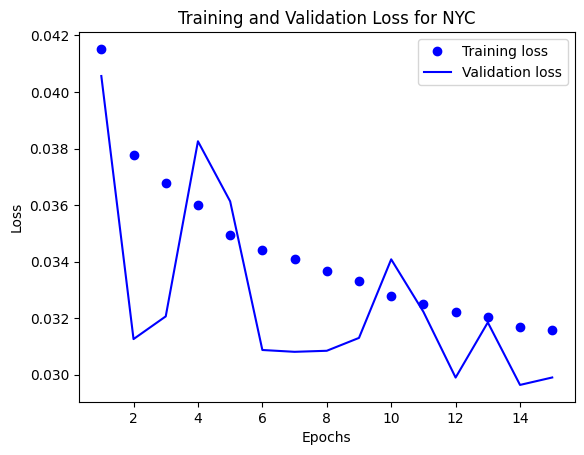

226/226 [==============================] - 0s 1ms/step
Mean Absolute Error for NYC: 0.047778476029634476


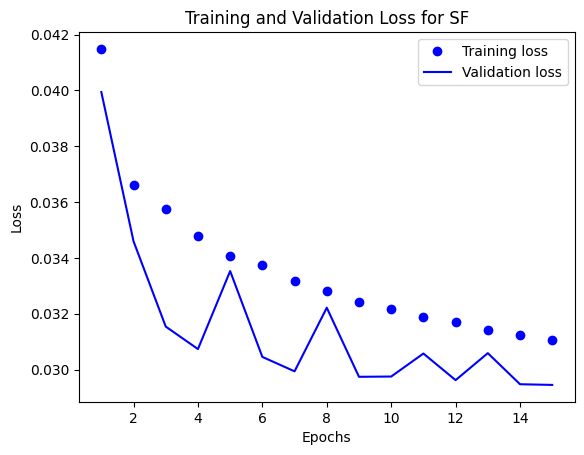

226/226 [==============================] - 0s 1ms/step
Mean Absolute Error for SF: 0.04858412966132164


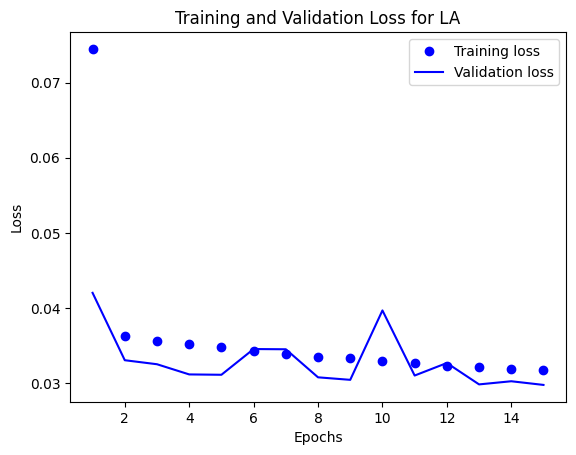

226/226 [==============================] - 0s 1ms/step
Mean Absolute Error for LA: 0.04706548526883125


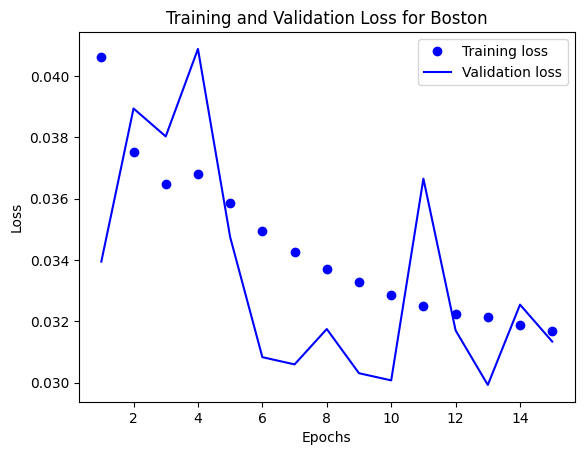

226/226 [==============================] - 0s 1ms/step
Mean Absolute Error for Boston: 0.04871968552470207


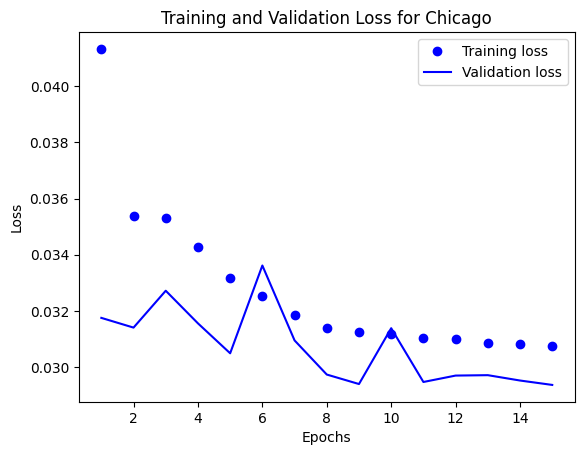

226/226 [==============================] - 0s 1ms/step
Mean Absolute Error for Chicago: 0.04947960004210472


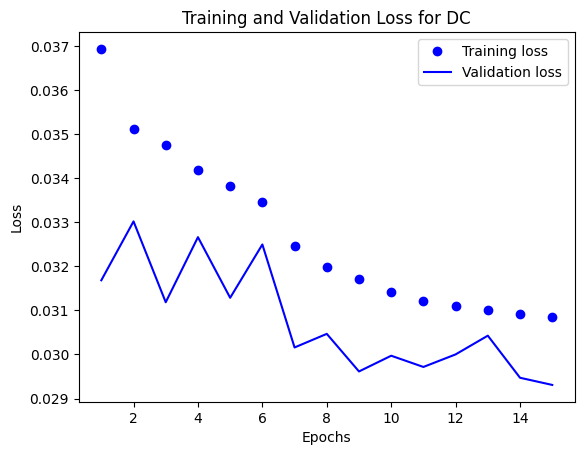

226/226 [==============================] - 0s 1ms/step
Mean Absolute Error for DC: 0.04765830934047699


In [9]:
# Build and test our neural network

# Define an empty list to store the data
mae_data = []

# Initialize lists to store training history
train_loss = []
val_loss = []

# Split the data into train and test groups
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)

# Iterate over each city
for city in unique_cities:
    cities_to_filter = ['NYC', 'SF', 'DC', 'LA', 'Boston', 'Chicago']
    X_city_train = X_train[df['city'].isin(cities_to_filter)]
    Y_city_train = Y_train[df['city'].isin(cities_to_filter)]
    X_city_test = X_test[df['city'].isin(cities_to_filter)]
    Y_city_test = Y_test[df['city'].isin(cities_to_filter)]

    scaler_city = RobustScaler()
    X_city_train_scaled = scaler_city.fit_transform(X_city_train)
    X_city_test_scaled = scaler_city.transform(X_city_test)

    model_city = tf.keras.Sequential([
        tf.keras.layers.Dense(18, activation='sigmoid', input_shape=(X_city_train_scaled.shape[1],)),
        tf.keras.layers.Dense(18, activation='sigmoid'),
        tf.keras.layers.Dense(18, activation='sigmoid'),
        tf.keras.layers.Dense(18, activation='ReLU'),
        tf.keras.layers.Dense(1)
    ])

    model_city.compile(optimizer='RMSprop', loss=tf.keras.losses.MeanAbsoluteError())

    history = model_city.fit(X_city_train_scaled, Y_city_train, epochs=15, batch_size=32, validation_split=0.2, verbose=0)

    # Print training and validation loss for the current city
    plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], 'bo', label='Training loss')
    plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], 'b', label='Validation loss')
    plt.title(f'Training and Validation Loss for {city}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    Y_city_pred = model_city.predict(X_city_test_scaled)
    mae_city = tf.keras.losses.MeanAbsoluteError()
    mae_value = mae_city(Y_city_test, Y_city_pred).numpy()
    mae_value_rounded = round(mae_value, 3)

    mae_data.append({'City': city, 'MAE': mae_value})

    print(f"Mean Absolute Error for {city}: {mae_value}")

Now we'll test how much each variable affects the predicted price in each city.

To do this, I'm creating a for loop that filters the dataframe by each city and removes each variable one at a time.

In [10]:
# Redirecting the code to a null device while I analyze the impact of each variable
original_stdout = sys.stdout
null_device = open(os.devnull, 'w')
sys.stdout = null_device

In [11]:
# Test the effects of each variable on the predicted price and MAE

# Create DataFrame to store the change in mae when each feature is removed
y_change_df = pd.DataFrame(columns=['City', 'Feature', 'Cost Difference', 'MAE Change'])

# Define the performance metric
mean_absolute_error = tf.keras.losses.MeanAbsoluteError()

# Iterate over each unique city
for city in unique_cities:
    cities_to_filter = ['NYC', 'SF', 'DC', 'LA', 'Boston', 'Chicago']
    X_city_train = X_train[df['city'].isin(cities_to_filter)]
    Y_city_train = Y_train[df['city'].isin(cities_to_filter)]
    X_city_test = X_test[df['city'].isin(cities_to_filter)]
    Y_city_test = Y_test[df['city'].isin(cities_to_filter)]

    original_columns = X_city_train.columns

    # Create the loop for our neural network
    for feature in original_columns:
        X_train_temp = X_city_train.drop(columns=feature)
        X_test_temp = X_city_test.drop(columns=feature)

        scaler_city = RobustScaler()
        X_city_train_scaled = scaler_city.fit_transform(X_train_temp)
        X_city_test_scaled = scaler_city.transform(X_test_temp)

        model_city = tf.keras.Sequential([
            tf.keras.layers.Dense(18, activation='sigmoid', input_shape=(X_city_train_scaled.shape[1],)),
            tf.keras.layers.Dense(18, activation='sigmoid'),
            tf.keras.layers.Dense(18, activation='sigmoid'),
            tf.keras.layers.Dense(18, activation='ReLU'),
            tf.keras.layers.Dense(1)
        ])

        # Compile the model
        model_city.compile(optimizer='RMSprop', loss=mean_absolute_error)

        # Train the model
        model_city.fit(X_city_train_scaled, Y_city_train, epochs=15, batch_size=32, validation_split=0.2, verbose=0)

        # Evaluate the model
        Y_pred_temp = model_city.predict(X_city_test_scaled)
        mae_temp = mean_absolute_error(Y_test, Y_pred_temp).numpy()

        # Calculate the change in MAE
        mae_change = mae_temp - mae_value

        # Calculate the change in the predicted price
        Y_pred_diff = Y_pred_temp - Y_city_pred

        y_change_df = pd.concat([y_change_df, pd.DataFrame({'City': [city], 'Feature': [feature], 'MAE Change': [mae_change], 'Cost Difference': [Y_pred_diff]})], ignore_index=True)



In [12]:
# Closing the null device and redicting the rest of the code to the original output
sys.stdout = original_stdout
null_device.close()

Now that we have our data, we'll clean it and make it more readable.

In [13]:
# Reset the index
y_change_df.reset_index(drop=True, inplace=True)

In [14]:
# Remove text and brackets from the MAE Change column
y_change_df['MAE Change'] = y_change_df['MAE Change'].apply(lambda x: str(x) if isinstance(x, (np.float32, float)) else str(x))
y_change_df['MAE Change'] = y_change_df['MAE Change'].str.replace(r"\[.*?\]", "").str.strip()

# Convert Cost Difference column to float
y_change_df['Cost Difference'] = y_change_df['Cost Difference'].apply(lambda x: x[0] if isinstance(x, np.ndarray) and len(x) > 0 else x)

# Create a function to convert the cost difference value to float
def convert_to_float(value):
    if isinstance(value, np.ndarray):
        return float(value[0])
    elif isinstance(value, str):
        return float(value.strip('[]'))
    elif isinstance(value, (float, int)):
        return float(value)
    else:
        return np.nan

# Apply the conversion function to the "Cost Difference" column
y_change_df['Cost Difference'] = y_change_df['Cost Difference'].apply(convert_to_float)

# Round the columns to 3 decimal places
y_change_df['MAE Change'] = y_change_df['MAE Change'].astype(float).round(3).astype(str)
y_change_df['Cost Difference'] = y_change_df['Cost Difference'].round(3)




In [15]:
# Convert the City column to strings
y_change_df['City'] = y_change_df['City'].astype(str)

# Group by the 'City' column
grouped_df = y_change_df.groupby('City')

# Dictionary to store separated and ordered DataFrames
city_dfs = {}

# Iterate over each group
for city, group_df in grouped_df:
    sorted_df = group_df.sort_values(by='Cost Difference')
    city_dfs[city] = sorted_df

# Assign each city's rows to their own dataframe
nyc_df = city_dfs['NYC'].copy()
sf_df = city_dfs['SF'].copy()
la_df = city_dfs['LA'].copy()
dc_df = city_dfs['DC'].copy()
boston_df = city_dfs['Boston'].copy()
chicago_df = city_dfs['Chicago'].copy()

In [16]:
# Reset the row #'s

nyc_df.reset_index(drop=True, inplace=True)
sf_df.reset_index(drop=True, inplace=True)
la_df.reset_index(drop=True, inplace=True)
dc_df.reset_index(drop=True, inplace=True)
boston_df.reset_index(drop=True, inplace=True)
chicago_df.reset_index(drop=True, inplace=True)


In [17]:
# Print the dataframes

print("New York City")
print(nyc_df)

print("San Francisco")
print(sf_df)

print("Los Angeles")
print(la_df)

print("Washington DC")
print(dc_df)

print("Boston")
print(boston_df)

print("Chicago")
print(chicago_df)

New York City
   City                    Feature  Cost Difference MAE Change
0   NYC       host_has_profile_pic           -0.005     -0.001
1   NYC  laptop_friendly_workspace           -0.001      0.002
2   NYC          wireless_internet            0.000     -0.001
3   NYC           instant_bookable           -0.000      0.004
4   NYC                       pool            0.000      0.002
5   NYC                      dryer            0.002       -0.0
6   NYC                   bedrooms            0.003     -0.002
7   NYC     host_identity_verified            0.003        0.0
8   NYC             smoke_detector            0.004      0.001
9   NYC                 hair_dryer            0.004     -0.001
10  NYC                       beds            0.005      0.002
11  NYC                       iron            0.005      0.001
12  NYC               cleaning_fee            0.006      0.001
13  NYC   carbon_monoxide_detector            0.007      0.002
14  NYC               kid_friendly       